In [1]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.datasets as datasets


Bad key "text.kerning_factor" on line 4 in
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# let’s initialize the MNIST train and test set.
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_batch_size = 6000
test_batch_size = 1000

In [5]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=test_batch_size, shuffle=False)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.maxpool(self.conv2(x)))
        x = F.relu(self.maxpool(self.conv3(x)))
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1) 
        return x
    
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
def evaluate(model):
#model = cnn
    correct = 0 
    for test_imgs, test_labels in test_loader:
        
        test_imgs = Variable(test_imgs).float()
                
        output = model.forward(test_imgs)
        
        predicted = torch.max(output,1)[1]
        
        correct += (predicted == test_labels).sum()
        accuracy = float(correct*100) / (len(test_loader)*test_batch_size)
    
    #print("Test accuracy:{:.3f} % ".format(accuracy))
    return accuracy

In [9]:
def fit(model, train_loader, epochs, optimizer, loss):
    
    epochs_list = []
    loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    if optimizer == 'Adam': 
        # Adam optimizer
        optimizer = torch.optim.Adam(model.parameters()) # lr=0.001, betas=(0.9,0.999))
    
    if loss == 'CrossEntropy':
        # cross entropy function
        error = nn.CrossEntropyLoss()
        
    for epoch in range(epochs):
                
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # wrapping tensors in variables,  If x is a Variable then x.data is a Tensor giving its value, 
            # and x.grad is another Variable holding the gradient of x with respect to some scalar value
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
                                    
            # we need to set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            
            # output of the model
            output = model.forward(var_X_batch)
                        
            # Calculating the loss 
            loss = error(output, var_y_batch)
            
            # Let's do backpropogation, it will calculate all the gradients and save to x.grad
            loss.backward()
            
            # Performs a single optimization step,  
            #parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule
            optimizer.step()
            
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            accuracy = float(correct*100) / float(train_batch_size*(batch_idx+1))
        
        # Training accuracy
        epochs_list.append(epoch)
        loss_list.append(loss.data)
        train_accuracy_list.append(accuracy)
        
        # Testing accuracy
        test_accuracy = evaluate(model)
        test_accuracy_list.append(test_accuracy)
        
        print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
            epoch+1, 
            (batch_idx+1)*(len(X_batch)), 
            len(train_loader.dataset), 
            100.*(batch_idx+1) / len(train_loader), 
            loss.data, 
            accuracy))
                                                  
    # accuracy Plot
    train_accuracy_array = np.array(train_accuracy_list)
    y_train_accuracy = train_accuracy_array.reshape(-1, 1)
    
    test_accuracy_array = np.array(test_accuracy_list)
    y_test_accuracy = test_accuracy_array.reshape(-1, 1)

    # Loss Plot
    loss_array_array = np.array(loss_list)
    y_loss = loss_array_array.reshape(-1, 1)
    
    x_epochs = np.array(epochs_list).reshape(-1, 1)
                                                  
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_epochs, y_loss)
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('epochs_vs_loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(x_epochs, y_train_accuracy, label='Training accuracy')
    plt.plot(x_epochs, y_test_accuracy, label='Testing accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('epochs_vs_accuracy')
    plt.legend()
    
    fig1 = plt.gcf()
    plt.show()

Epoch : 1 [60000/60000 (100%)]	Loss: 0.838614	 Accuracy:52.533%
Epoch : 2 [60000/60000 (100%)]	Loss: 0.385478	 Accuracy:81.220%
Epoch : 3 [60000/60000 (100%)]	Loss: 0.266450	 Accuracy:88.382%
Epoch : 4 [60000/60000 (100%)]	Loss: 0.188189	 Accuracy:91.783%
Epoch : 5 [60000/60000 (100%)]	Loss: 0.141432	 Accuracy:93.803%
Epoch : 6 [60000/60000 (100%)]	Loss: 0.114806	 Accuracy:95.137%
Epoch : 7 [60000/60000 (100%)]	Loss: 0.094251	 Accuracy:96.113%
Epoch : 8 [60000/60000 (100%)]	Loss: 0.080665	 Accuracy:96.735%
Epoch : 9 [60000/60000 (100%)]	Loss: 0.071022	 Accuracy:97.152%
Epoch : 10 [60000/60000 (100%)]	Loss: 0.063561	 Accuracy:97.502%
Epoch : 11 [60000/60000 (100%)]	Loss: 0.058229	 Accuracy:97.770%
Epoch : 12 [60000/60000 (100%)]	Loss: 0.053253	 Accuracy:97.953%
Epoch : 13 [60000/60000 (100%)]	Loss: 0.049283	 Accuracy:98.155%
Epoch : 14 [60000/60000 (100%)]	Loss: 0.046218	 Accuracy:98.285%
Epoch : 15 [60000/60000 (100%)]	Loss: 0.043238	 Accuracy:98.388%


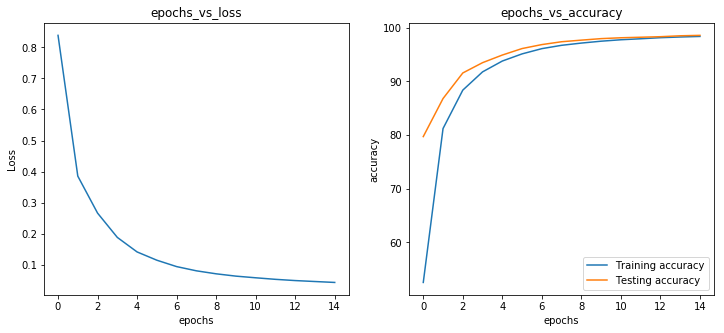

In [11]:
fit(cnn, train_loader, epochs=15, optimizer='Adam', loss='CrossEntropy')